In [129]:
#!pip install wordcloud textblob -q

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import warnings
from textblob import TextBlob
from collections import Counter
import nltk
from matplotlib.patches import Wedge

nltk.download('punkt', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# Asegúrate de haber descargado las stopwords de 'english'
#nltk.download('stopwords') # Ejecutar una vez

# Cargar stopwords de inglés si tu dataset es en inglés
stopwords_english = set(nltk.corpus.stopwords.words('english'))

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette("husl")


In [130]:
def buscar_tweets_health():
    """Buscar tweets específicamente sobre 'health'"""

    print("🔍 BUSCANDO TWEETS SOBRE 'HEALTH'...")

    columnas = ['target', 'ids', 'date', 'flag', 'user', 'text']

    print("📂 Cargando dataset base...")
    df_completo = pd.read_csv('training.1600000.processed.noemoticon.csv',
                             encoding='latin-1',
                             names=columnas,
                             nrows=150000)  # Cargar bastante para tener buena muestra

    print(f"✅ Dataset cargado: {len(df_completo):,} tweets")

    # Buscar tweets que contengan "health" (incluyendo variaciones)
    palabras_salud = ['health', 'healthy', 'healthcare', 'wellness', 'medical']

    # Crear patrón de búsqueda
    patron = '|'.join(palabras_salud)
    mascara = df_completo['text'].str.contains(patron, case=False, na=False)
    df_health = df_completo[mascara].copy()

    print(f"🎯 Tweets encontrados sobre salud: {len(df_health):,}")

    # Tomar muestra representativa si hay muchos
    if len(df_health) > 5000:
        df_health = df_health.sample(n=5000, random_state=42)
        print(f"📊 Muestra reducida a {len(df_health):,} tweets para análisis")

    return df_health


df_health = buscar_tweets_health()

🔍 BUSCANDO TWEETS SOBRE 'HEALTH'...
📂 Cargando dataset base...
✅ Dataset cargado: 150,000 tweets
🎯 Tweets encontrados sobre salud: 183


In [ ]:
def procesar_tweets_health(df):

    print("\n🔄 PROCESANDO TWEETS SOBRE SALUD...")

    # Mapear sentimientos originales
    sentiment_map = {0: 'Negativo', 2: 'Neutral', 4: 'Positivo'}
    df['sentimiento_original'] = df['target'].map(sentiment_map)

    # Procesamiento de texto
    def limpiar_texto_salud(texto):
        # Filtramos los valores nulos
        if pd.isna(texto):
            return "" # Retornamos un valor vacio
        
        # Normalizamos a letras minusculas
        texto = str(texto).lower()

        # Conservamos una lista de términos clave e importantes de salud

        health_terms = ['health', 'healthy', 'healthcare', 'medical', 'doctor',
                       'hospital', 'medicine', 'wellness', 'fitness', 'disease']
        
        # Iteramos cada término clave para reemplazarlo dentro del texto en mayuscula.
        # ¿Para que? Con el fin de darle cierto peso con TextBlob.
        for term in health_terms:
            texto = texto.replace(term, f" {term.upper()} ")

        # Limpieza de Tweets: URLs, menciones, etc.

        # Identifica URLs, menciones de usuarios y hashtags. Estos son reemplazados por una cadena vacia.
        texto = re.sub(r'http\S+|www\S+|@\w+|#[a-zA-Z0-9_]+', '', texto) 
        # Identifica todo lo que no sea letra y son reemplazados por un espacio en blanco.
        texto = re.sub(r'[^a-zA-Z\s]', ' ', texto)   
        
        # Tokenización explícita para la eliminación de stopwords

        # Divide la cadena en una lista de palabras(tokens)
        tokens = texto.split() 
        
        # Eliminar stopwords
        tokens_sin_stopwords = [word for word in tokens if word not in stopwords_english]
        
        # Vuelve a unir los tokens limpios en una cadena
        texto=' '.join(tokens_sin_stopwords)

        return texto 
    # Creamos en el df una nueva columna [texto_limpio] donde le aplicamos a cada fila la función limpiar_texto_salud
    df['texto_limpio'] = df['text'].apply(limpiar_texto_salud)

    # Análisis de sentimientos con TextBlob
    print("🔍 Analizando sentimientos sobre salud...")
    def analizar_sentimiento(texto):
        try:
            blob = TextBlob(texto) # Creamos una variable de tipo TextBlob.
            pol = blob.sentiment.polarity # Extraemos la polaridad del sentimiento.
            # Clasificamos el sentimiento en 3 categorias.
            if pol > 0.1: return 'Positivo', pol
            elif pol < -0.1: return 'Negativo', pol
            else: return 'Neutral', pol
        except:
            return 'Neutral', 0.0
        
    #Almacenamiento de Resultados
    # Creamos una variable resultado para almacenar el resultado del anilisis del sentimiento.
    resultados = df['texto_limpio'].apply(analizar_sentimiento)
    # Creamos una nueva columna[sentimiento_textblob] en el df e iterando la variable resultado agregarmos un valor en cada fila.
    df['sentimiento_textblob'] = [r[0] for r in resultados]
    # Creamos una nueva columna[polaridad] en el df  e iterando la variable resultado agregarmos un valor en cada fila.
    df['polaridad'] = [r[1] for r in resultados]

    # Estadísticas específicas sobre salud
    print(f"\n📊 ESTADÍSTICAS SOBRE TWEETS DE SALUD:")
    print(f"• Total de tweets analizados: {len(df):,}")
    print(f"• Polaridad promedio: {df['polaridad'].mean():.3f}")

    # Distribución de sentimientos
    print(f"\n📈 ¿Cómo habla la gente sobre salud? (Etiquetas originales):")
    for sent, count in df['sentimiento_original'].value_counts().items():
        pct = (count/len(df))*100
        print(f"  • {sent}: {count:,} tweets ({pct:.1f}%)")

    # Distribución con TextBlob
    print(f"\n🔍 Análisis con TextBlob:")
    for sent, count in df['sentimiento_textblob'].value_counts().items():
        pct = (count/len(df))*100
        print(f"  • {sent}: {count:,} tweets ({pct:.1f}%)")

    return df

df_health = procesar_tweets_health(df_health)


🔄 PROCESANDO TWEETS SOBRE SALUD...
🔍 Analizando sentimientos sobre salud...

📊 ESTADÍSTICAS SOBRE TWEETS DE SALUD:
• Total de tweets analizados: 183
• Polaridad promedio: -0.022

📈 ¿Cómo habla la gente sobre salud? (Etiquetas originales):
  • Negativo: 183 tweets (100.0%)

🔍 Análisis con TextBlob:
  • Neutral: 80 tweets (43.7%)
  • Positivo: 53 tweets (29.0%)
  • Negativo: 50 tweets (27.3%)



📊 CREANDO VISUALIZACIONES SOBRE SALUD...
Advertencia: No hay usuarios con más de 5 tweets. Mostrando los 10 usuarios más activos.


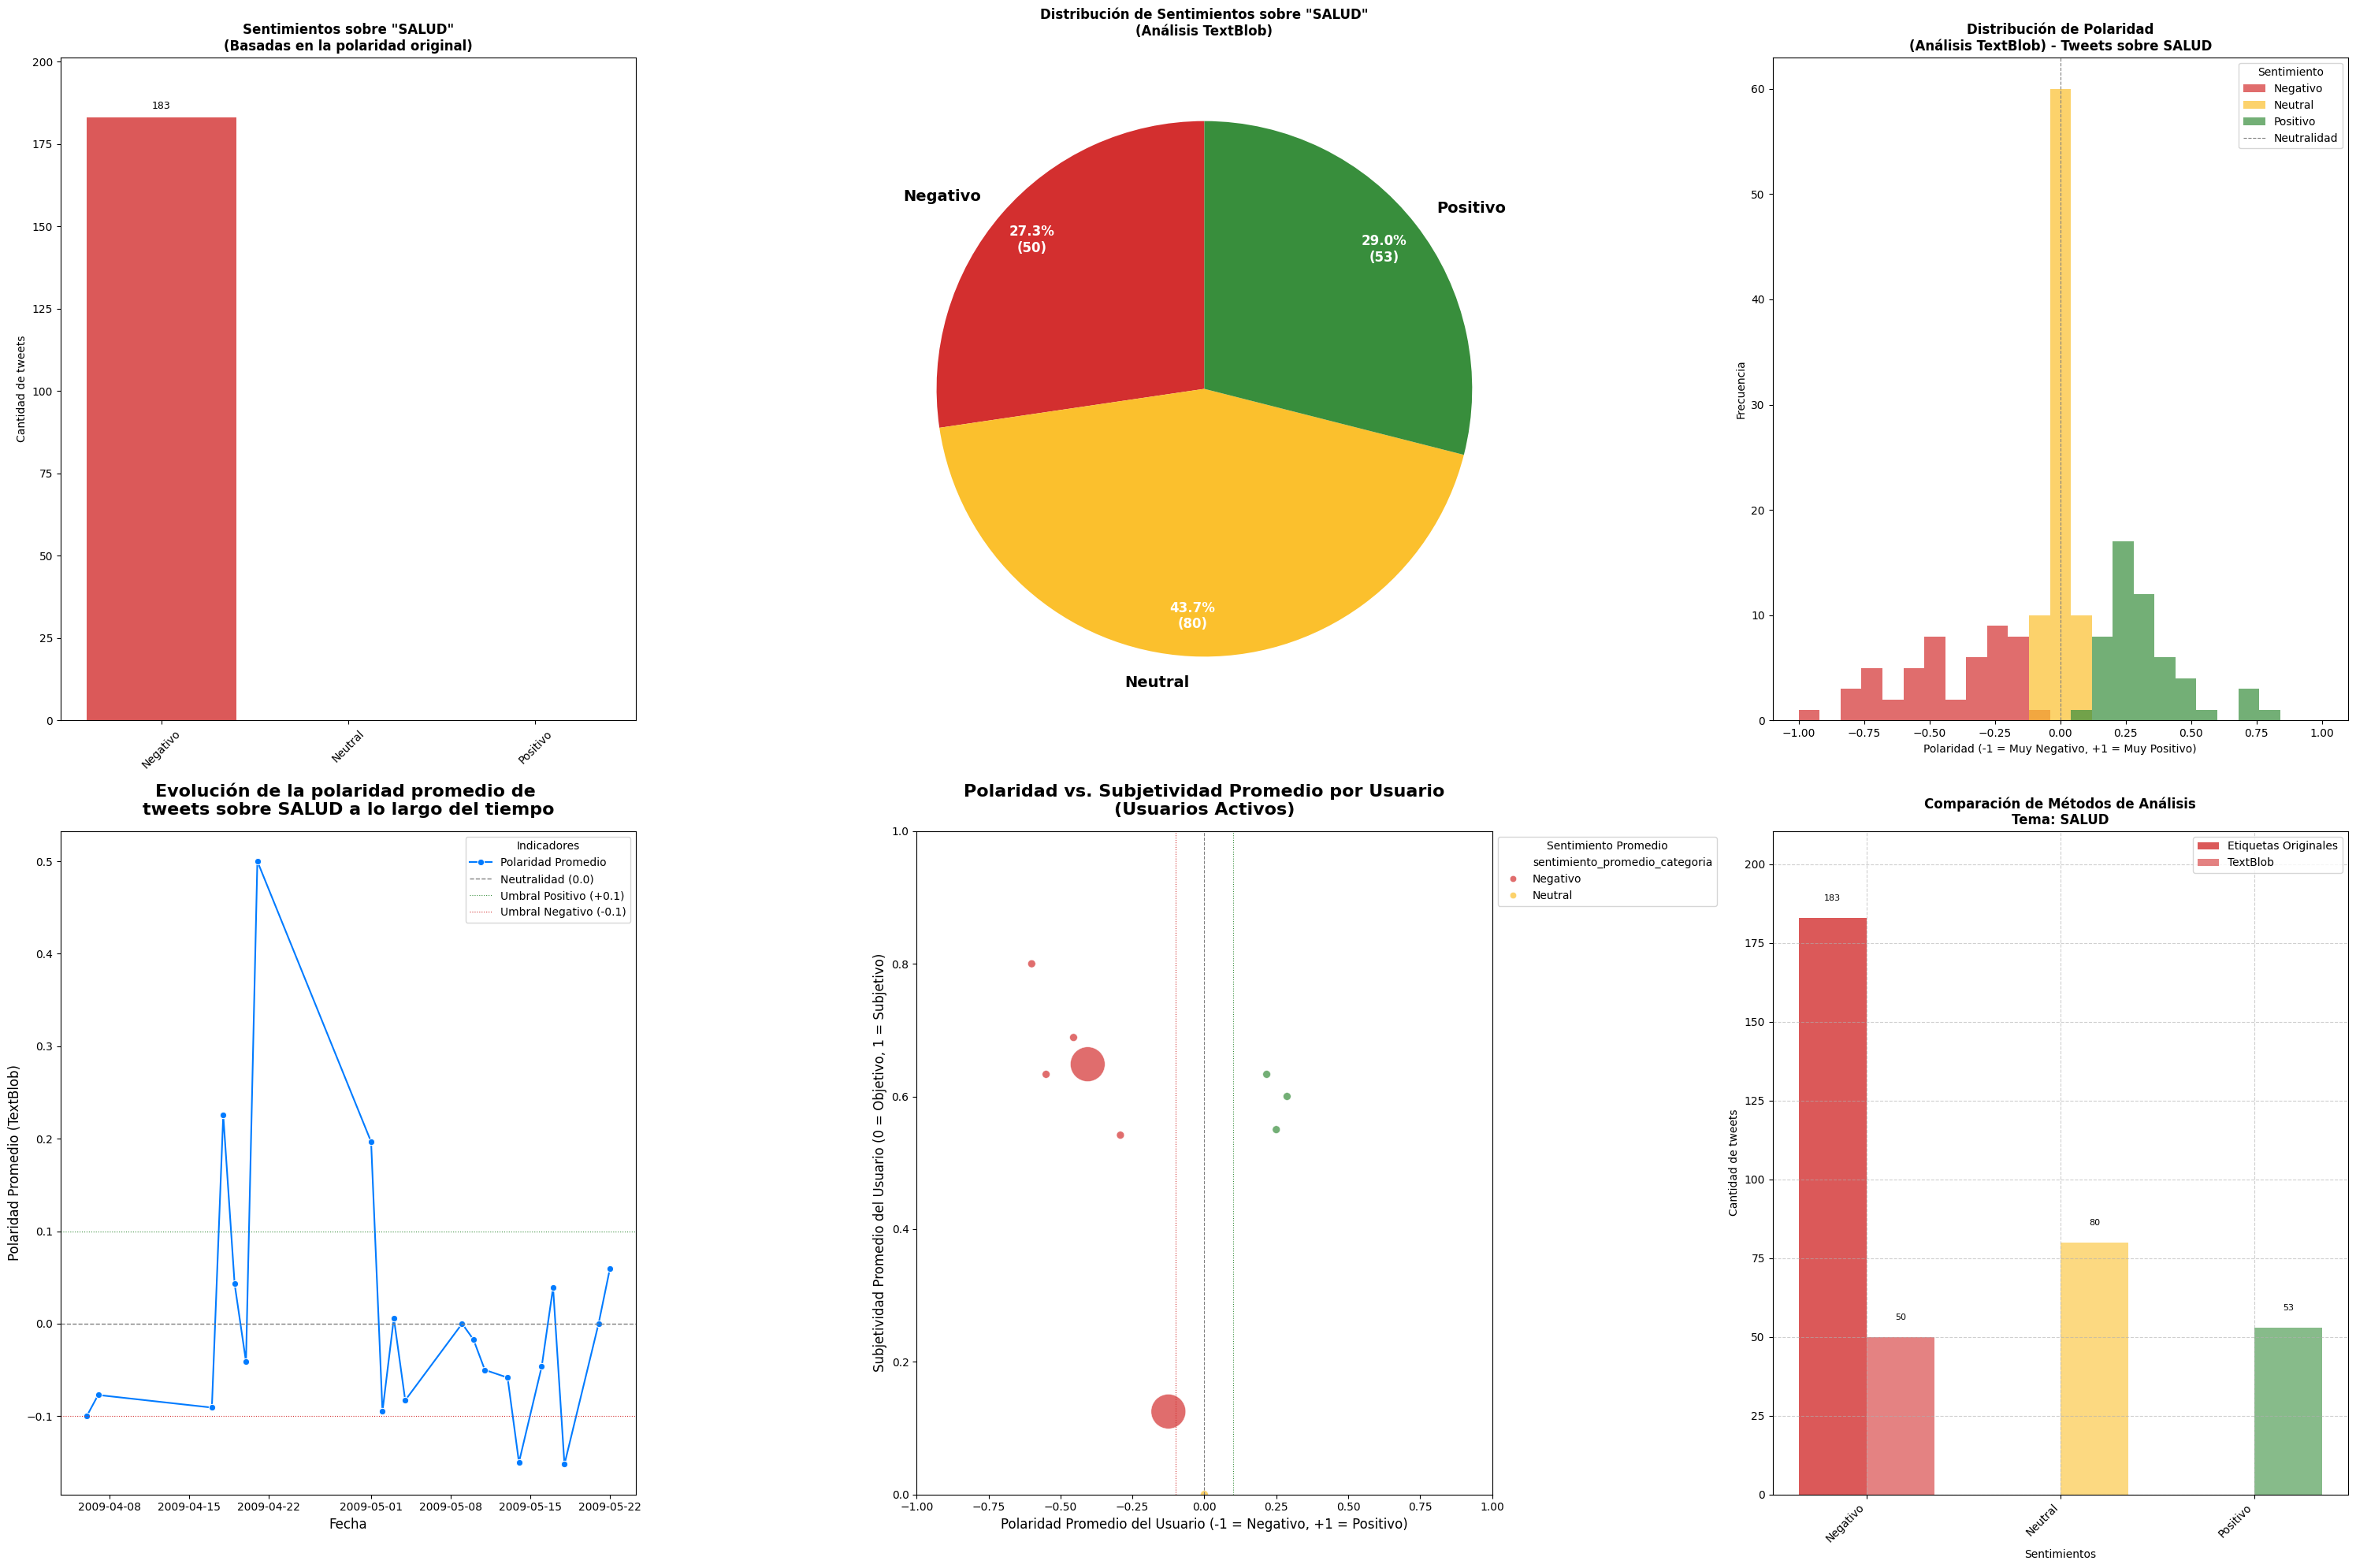

In [133]:
def crear_visualizaciones_health(df):

    print("\n📊 CREANDO VISUALIZACIONES SOBRE SALUD...")

    # Configurar figura principal
    fig, axes = plt.subplots(2, 3, figsize=(30, 20))
    colors_sentiment = {
    'Negativo': '#D32F2F',  # Rojo más oscuro y estándar
    'Neutral': '#FBC02D',   # Amarillo más intenso
    'Positivo': '#388E3C'   # Verde más oscuro y estándar
    }
    sentiment_order = ['Negativo', 'Neutral', 'Positivo']


    # 1. Distribución de sentimientos originales
    orig_counts = df['sentimiento_original'].value_counts()
    bar_colors = [colors_sentiment[s] for s in sentiment_order if s in orig_counts.index]
    orig_counts_ordered = orig_counts.reindex(sentiment_order).fillna(0)

    axes[0,0].bar(orig_counts_ordered.index, orig_counts_ordered.values, color=bar_colors, alpha=0.8)
    axes[0,0].set_title('Sentimientos sobre "SALUD"\n(Basadas en la polaridad original)',fontsize=12, fontweight='bold')
    axes[0,0].set_ylabel('Cantidad de tweets')
    axes[0,0].tick_params(axis='x', rotation=45)
    for i, v in enumerate(orig_counts_ordered.values):
        if v > 0: # Solo mostrar si hay tweets para esa categoría
            axes[0,0].text(i, v + (df.shape[0] * 0.01), f'{int(v):,}',
                       ha='center', va='bottom', fontsize=9)
    axes[0,0].set_ylim(0, orig_counts_ordered.max() * 1.1)


    # 2. Distribución TextBlob
    tb_counts = df['sentimiento_textblob'].value_counts()
    tb_counts_ordered = tb_counts.reindex(sentiment_order).fillna(0)
    labels_pie = [s for s in sentiment_order if tb_counts_ordered[s] > 0]
    values_pie = [tb_counts_ordered[s] for s in sentiment_order if tb_counts_ordered[s] > 0]
    colors_pie = [colors_sentiment[s] for s in sentiment_order if tb_counts_ordered[s] > 0]

    def autopct_format_pie(value):
        total_tweets = sum(values_pie) # El total es la suma de los valores que realmente se grafican
        absolute_value = int(round(value * total_tweets / 100.0)) # Calcular el valor absoluto
        return f'{value:.1f}%\n({absolute_value:,})'
    
    wedges, texts, autotexts = axes[0,1].pie(
        values_pie,
        labels=labels_pie, # Etiquetas de las categorías (Negativo, Neutral, Positivo)
        colors=colors_pie, # Los colores de semáforo que ya definiste
        autopct=autopct_format_pie, # Función para mostrar % y valor absoluto
        startangle=90, # Inicia el primer segmento desde la parte superior
        pctdistance=0.85, # Distancia de los textos de porcentaje del centro
        #wedgeprops={'edgecolor': 'black'} # Borde negro para los segmentos
    )
    plt.setp(autotexts, size=12, weight="bold", color="white") # Textos de porcentaje (blanco para contraste)
    plt.setp(texts, size=14, weight="bold", color="black") # Etiquetas de categorías (Negativo, etc.)
    # Ajustar el título
    axes[0,1].set_title('Distribución de Sentimientos sobre "SALUD"\n(Análisis TextBlob)',fontsize=12, fontweight='bold', pad=20)
    axes[0,1].axis('equal')


    # 3. Distribución de polaridad
    ax = axes[0,2]
    bins = np.linspace(-1, 1, 26)
    # Histograma para sentimientos Negativos
    ax.hist(df[df['sentimiento_textblob'] == 'Negativo']['polaridad'],
        bins=bins,
        alpha=0.7, # Transparencia para ver si se superponen
        color=colors_sentiment['Negativo'],
        #edgecolor='black', # Borde de las barras
        label='Negativo') # Etiqueta para la leyenda
    # Histograma para sentimientos Neutrales
    ax.hist(df[df['sentimiento_textblob'] == 'Neutral']['polaridad'],
        bins=bins,
        alpha=0.7,
        color=colors_sentiment['Neutral'],
        #edgecolor='black',
        label='Neutral')
    # Histograma para sentimientos Positivos
    ax.hist(df[df['sentimiento_textblob'] == 'Positivo']['polaridad'],
        bins=bins,
        alpha=0.7,
        color=colors_sentiment['Positivo'],
        #edgecolor='black',
        label='Positivo')
    # Configurar títulos y etiquetas del gráfico
    ax.set_title('Distribución de Polaridad\n(Análisis TextBlob) - Tweets sobre SALUD',fontsize=12, fontweight='bold')
    ax.set_xlabel('Polaridad (-1 = Muy Negativo, +1 = Muy Positivo)')
    ax.set_ylabel('Frecuencia')
    # Añadir una leyenda para diferenciar los colores
    ax.legend(title='Sentimiento')
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Neutralidad')
    ax.legend(title='Sentimiento') # Actualizar la leyenda después de añadir la línea
    

    # 4. Análisis de Sentimiento a lo Largo del Tiempo
    df['date_format'] = pd.to_datetime(df['date'])
    df_daily_sentiment = df.groupby(df['date_format'].dt.date)['polaridad'].mean().reset_index()
    df_daily_sentiment.columns = ['date_format', 'polaridad_promedio'] # Renombrar columnas

    df_time_series = df_daily_sentiment
    
    ax = axes[1,0]
    sns.lineplot(x='date_format', y='polaridad_promedio', data=df_time_series, ax=ax, marker='o',
             color='#007bff', # Un azul agradable
             label='Polaridad Promedio')
    ax.set_title('Evolución de la polaridad promedio de \ntweets sobre SALUD a lo largo del tiempo',fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Fecha', fontsize=12)
    ax.set_ylabel('Polaridad Promedio (TextBlob)', fontsize=12)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1, label='Neutralidad (0.0)')
    ax.axhline(0.1, color='#388E3C', linestyle=':', linewidth=0.8, label='Umbral Positivo (+0.1)') # Verde
    ax.axhline(-0.1, color='#D32F2F', linestyle=':', linewidth=0.8, label='Umbral Negativo (-0.1)') # Rojo
    plt.xticks(rotation=45, ha='right')
    ax.legend(title='Indicadores')
    plt.grid(True, linestyle='--', alpha=0.6)


    # 5. Análisis de Usuarios por Sentimiento y Subjetividad
    # Calculado la subjetividad
    def analizar_sentimiento_subjetividad(texto):
        try:
            blob = TextBlob(texto)
            return blob.sentiment.polarity, blob.sentiment.subjectivity
        except:
            return 0.0, 0.0
    resultados_full = df['texto_limpio'].apply(analizar_sentimiento_subjetividad)
    #df['polaridad'] = [r[0] for r in resultados_full]
    df['subjetividad'] = [r[1] for r in resultados_full]

    user_sentiment_stats = df.groupby('user').agg(
    polaridad_promedio=('polaridad', 'mean'),
    subjetividad_promedio=('subjetividad', 'mean'),
    conteo_tweets=('text', 'count')
    ).reset_index()

    min_tweets_for_analysis = 5 # Ajusta este umbral según la distribución de tus datos
    active_users_stats = user_sentiment_stats[user_sentiment_stats['conteo_tweets'] >= min_tweets_for_analysis].copy()
    
    # Si no hay usuarios activos con el umbral, reduce el umbral o toma el top N
    if active_users_stats.empty and not user_sentiment_stats.empty:
        print(f"Advertencia: No hay usuarios con más de {min_tweets_for_analysis} tweets. Mostrando los 10 usuarios más activos.")
        active_users_stats = user_sentiment_stats.nlargest(10, 'conteo_tweets').copy()
    elif active_users_stats.empty:
        print("No hay datos de usuario para graficar.")
        # Puedes salir de la función o manejar este caso como prefieras
        exit()

    # Usa tus umbrales de TextBlob para categorizar a cada usuario
    def classify_user_sentiment(polaridad):
        if polaridad > 0.1:
            return 'Positivo'
        elif polaridad < -0.1:
            return 'Negativo'
        else:
            return 'Neutral'
    active_users_stats['sentimiento_promedio_categoria'] = active_users_stats['polaridad_promedio'].apply(classify_user_sentiment)
    
    # --- Configurar el gráfico de dispersión ---
    ax = axes[1,1]
    scatter = sns.scatterplot(
        x='polaridad_promedio',
        y='subjetividad_promedio',
        data=active_users_stats,
        hue='sentimiento_promedio_categoria', # Colorear por categoría de sentimiento
        palette=colors_sentiment,       # Usar tu paleta de colores de semáforo
        size='conteo_tweets',                # Tamaño del punto por conteo de tweets
        sizes=(50, 1000),                    # Rango de tamaños de los puntos
        alpha=0.7,                           # Transparencia
        edgecolor='w',                       # Borde blanco para los puntos
        linewidth=0.5,
        ax=ax
    )

    # Añadir títulos y etiquetas
    ax.set_title('Polaridad vs. Subjetividad Promedio por Usuario\n(Usuarios Activos)',
                fontsize=16, fontweight='bold', pad=15)
    ax.set_xlabel('Polaridad Promedio del Usuario (-1 = Negativo, +1 = Positivo)', fontsize=12)
    ax.set_ylabel('Subjetividad Promedio del Usuario (0 = Objetivo, 1 = Subjetivo)', fontsize=12)

    # Añadir líneas de referencia para los umbrales de sentimiento en polaridad
    ax.axvline(0.1, color='#388E3C', linestyle=':', linewidth=0.8, label='Umbral Positivo (+0.1)')
    ax.axvline(-0.1, color='#D32F2F', linestyle=':', linewidth=0.8, label='Umbral Negativo (-0.1)')
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.8, label='Polaridad Neutral (0.0)')

    # Ajustar límites de los ejes para mejor visualización
    ax.set_xlim(-1, 1) # Polaridad siempre va de -1 a 1
    ax.set_ylim(0, 1) # Subjetividad siempre va de 0 a 1

    # Mejorar la leyenda para el tamaño
    handles, labels = ax.get_legend_handles_labels()
    hue_labels = labels[:len(colors_sentiment)]
    hue_handles = handles[:len(colors_sentiment)]
    ax.legend(hue_handles, hue_labels, title='Sentimiento Promedio', loc='upper left', bbox_to_anchor=(1, 1))


    # 6. Comparación de métodos
    comparison_data = {
        'Original': [orig_counts.get('Negativo', 0), orig_counts.get('Neutral', 0), orig_counts.get('Positivo', 0)],
        'TextBlob': [tb_counts.get('Negativo', 0), tb_counts.get('Neutral', 0), tb_counts.get('Positivo', 0)]
    }

    x = np.arange(3)
    width = 0.35
    sentimientos = ['Negativo', 'Neutral', 'Positivo']
    ordered_colors = [colors_sentiment[s] for s in sentimientos]

    axes[1,2].bar(x - width/2, comparison_data['Original'], width,
                  label='Etiquetas Originales', color=ordered_colors, alpha=0.8)
    axes[1,2].bar(x + width/2, comparison_data['TextBlob'], width,
                  label='TextBlob', color=ordered_colors, alpha=0.6)

    axes[1,2].set_xlabel('Sentimientos')
    axes[1,2].set_ylabel('Cantidad de tweets')
    axes[1,2].set_title('Comparación de Métodos de Análisis\nTema: SALUD',
                        fontsize=12, fontweight='bold')
    axes[1,2].set_xticks(x)
    axes[1,2].set_xticklabels(sentimientos)
    axes[1,2].legend()
    # Para las barras 'Original'
    for i, val in enumerate(comparison_data['Original']):
        if val > 0: # Solo si el valor es mayor que 0
            axes[1,2].text(x[i] - width/2, val + 5, str(int(val)),
                        ha='center', va='bottom', fontsize=8) # Ajusta 5 para el padding

    # Para las barras 'TextBlob'
    for i, val in enumerate(comparison_data['TextBlob']):
        if val > 0: # Solo si el valor es mayor que 0
            axes[1,2].text(x[i] + width/2, val + 5, str(int(val)),
                        ha='center', va='bottom', fontsize=8) # Ajusta 5 para el padding

    # Ajusta el límite superior del eje Y para que las etiquetas no se corten
    max_val = max(max(comparison_data['Original']), max(comparison_data['TextBlob']))
    axes[1,2].set_ylim(0, max_val * 1.15) # 15% de padding


    plt.tight_layout()
    plt.show()

# CREAR VISUALIZACIONES
crear_visualizaciones_health(df_health)


🔸 TEMAS DE SALUD ASOCIADOS CON SENTIMIENTO POSITIVO:
   • health: 50 menciones
   • medical: 4 menciones
   • care: 2 menciones
   • painting: 1 menciones
   • scared: 1 menciones
   • careful: 1 menciones
   • painful: 1 menciones

🔸 TEMAS DE SALUD ASOCIADOS CON SENTIMIENTO NEGATIVO:
   • health: 48 menciones
   • sick: 9 menciones
   • medical: 4 menciones
   • pain: 2 menciones
   • care: 1 menciones

🔸 TEMAS DE SALUD ASOCIADOS CON SENTIMIENTO NEUTRAL:
   • health: 72 menciones
   • medical: 11 menciones
   • care: 4 menciones

☁️ CREANDO NUBES DE PALABRAS - CONTEXTO DE SALUD...


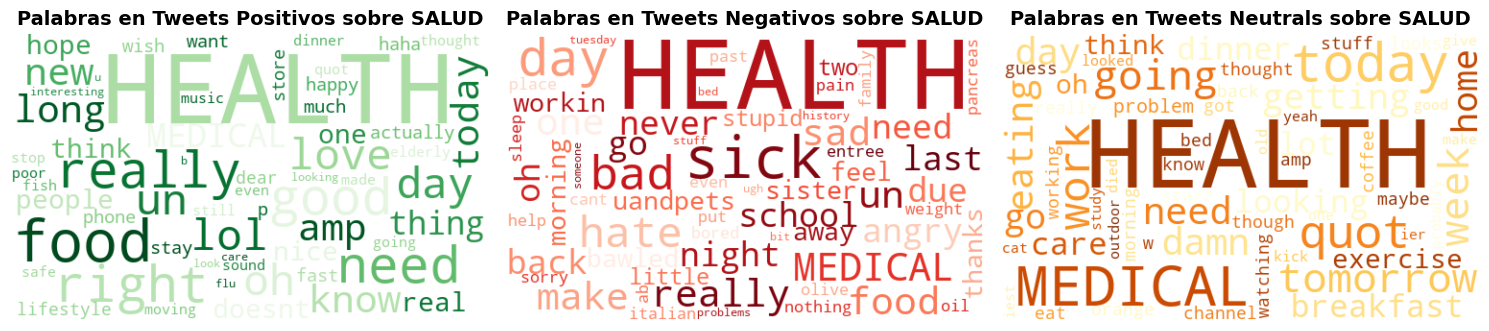


📝 EJEMPLOS DE TWEETS SOBRE SALUD:

🔸 TWEETS POSITIVOS SOBRE SALUD:

   📱 Tweet: Last day of health class  so sad. @TomFelton those pancakes sound good! can i have some?...
      🤖 TextBlob dice: Positivo (polaridad: 0.15)

   📱 Tweet: Long day of moving and painting with the fam, they even &quot;treated&quot; me to a huge McDonnalds dinner   people need...
      🤖 TextBlob dice: Positivo (polaridad: 0.18)

🔸 TWEETS NEGATIVOS SOBRE SALUD:

   📱 Tweet: @Health4UandPets saw the one with a GSD covered in them, and I could not stop crying. I just bawled and bawled ...
      🤖 TextBlob dice: Negativo (polaridad: -0.20)

   📱 Tweet: The nowhere land - not 100% sick, but definately not healthy either ...
      🤖 TextBlob dice: Negativo (polaridad: -0.71)

🔸 TWEETS NEUTRALS SOBRE SALUD:

   📱 Tweet: Have an invite for &quot;Healthy Dining&quot; session at Ashok Hotel today with Exec Chef R.Chopra but damn workload - w...
      🤖 TextBlob dice: Neutral (polaridad: 0.00)

   📱 Tweet: @dark_butte

In [136]:
def analizar_contexto_health(df):
    # Palabras más asociadas con cada sentimiento
    for sentimiento in ['Positivo', 'Negativo', 'Neutral']:
        if sentimiento in df['sentimiento_textblob'].values:
            print(f"\n🔸 TEMAS DE SALUD ASOCIADOS CON SENTIMIENTO {sentimiento.upper()}:")

            # Obtener texto de este sentimiento
            texto = ' '.join(df[df['sentimiento_textblob']==sentimiento]['texto_limpio'])

            # Contar palabras específicas de salud
            palabras = texto.lower().split()
            # Filtrar palabras relacionadas con salud
            palabras_salud = [p for p in palabras if len(p) > 3 and
                            any(term in p for term in ['health', 'medical', 'doctor', 'hospital',
                                                      'medicine', 'disease', 'care', 'wellness',
                                                      'fitness', 'sick', 'pain', 'treatment'])]

            # Top 10 palabras más comunes
            contador = Counter(palabras_salud)
            top_palabras = contador.most_common(10)

            for palabra, frecuencia in top_palabras:
                print(f"   • {palabra}: {frecuencia} menciones")

def crear_nube_palabras_health(df):

    print(f"\n☁️ CREANDO NUBES DE PALABRAS - CONTEXTO DE SALUD...")

    sentimientos = ['Positivo', 'Negativo', 'Neutral']  # Enfocarse en los más relevantes
    fig, axes = plt.subplots(1, 3, figsize=(15, 6))

    colormaps = ['Greens', 'Reds', 'YlOrBr']

    for i, sentimiento in enumerate(sentimientos):
        if sentimiento in df['sentimiento_textblob'].values:
            # Obtener texto para este sentimiento
            texto = ' '.join(df[df['sentimiento_textblob']==sentimiento]['texto_limpio'])

            if len(texto.strip()) > 50:
                try:
                    wordcloud = WordCloud(
                        width=500, height=300,
                        background_color='white',
                        max_words=60,
                        colormap=colormaps[i],
                        collocations=False
                    ).generate(texto)

                    axes[i].imshow(wordcloud, interpolation='bilinear')
                    axes[i].set_title(f'Palabras en Tweets {sentimiento}s sobre SALUD',fontsize=14, fontweight='bold')
                    axes[i].axis('off')
                except:
                    axes[i].text(0.5, 0.5, 'Error al generar\nnube de palabras',ha='center', va='center', transform=axes[i].transAxes)
                    axes[i].set_title(f'{sentimiento}', fontweight='bold')

    plt.tight_layout()
    plt.show()

def mostrar_ejemplos_health(df):

    print(f"\n📝 EJEMPLOS DE TWEETS SOBRE SALUD:")
    print("="*60)

    for sentimiento in ['Positivo', 'Negativo', 'Neutral']:
        if sentimiento in df['sentimiento_textblob'].values:
            ejemplos = df[df['sentimiento_textblob']==sentimiento].head(2)
            print(f"\n🔸 TWEETS {sentimiento.upper()}S SOBRE SALUD:")

            for idx, ejemplo in ejemplos.iterrows():
                print(f"\n   📱 Tweet: {ejemplo['text'][:120]}...")
                print(f"      🤖 TextBlob dice: {ejemplo['sentimiento_textblob']} (polaridad: {ejemplo['polaridad']:.2f})")

# EJECUTAR ANÁLISIS CONTEXTUAL
analizar_contexto_health(df_health)
crear_nube_palabras_health(df_health)
mostrar_ejemplos_health(df_health)

In [42]:
def resumen_health(df):

    total_tweets = len(df)
    polaridad_promedio = df['polaridad'].mean()

    # Sentimiento predominante
    sentimiento_predominante = df['sentimiento_textblob'].mode()[0]
    porcentaje_predominante = (df['sentimiento_textblob'] == sentimiento_predominante).mean() * 100

    print(f"📊 DATOS CLAVE:")
    print(f"• Total de tweets sobre salud analizados: {total_tweets:,}")
    print(f"• Sentimiento predominante: {sentimiento_predominante} ({porcentaje_predominante:.1f}%)")
    print(f"• Polaridad promedio: {polaridad_promedio:.3f}")

    # Interpretación de resultados
    if polaridad_promedio > 0.1:
        interpretacion = "POSITIVA"
        mensaje = "La gente tiende a hablar de manera optimista sobre temas de salud"
    elif polaridad_promedio < -0.1:
        interpretacion = "NEGATIVA"
        mensaje = "Existe preocupación o negatividad en las conversaciones sobre salud"
    else:
        interpretacion = "NEUTRAL/MIXTA"
        mensaje = "Las opiniones sobre salud están balanceadas entre positivas y negativas"

    print(f"\n🎯 CONCLUSIÓN PRINCIPAL:")
    print(f"La percepción general sobre SALUD en Twitter es: {interpretacion}")
    print(f"Interpretación: {mensaje}")

    # Insights específicos
    print(f"\n💡 INSIGHTS:")
    print(f"• La salud genera {total_tweets:,} conversaciones en la muestra analizada")
    print(f"• El {porcentaje_predominante:.0f}% de las conversaciones son {sentimiento_predominante.lower()}s")

    if 'Positivo' in df['sentimiento_textblob'].values:
        pos_pct = (df['sentimiento_textblob'] == 'Positivo').mean() * 100
        print(f"• {pos_pct:.1f}% de tweets expresan optimismo sobre salud")

    if 'Negativo' in df['sentimiento_textblob'].values:
        neg_pct = (df['sentimiento_textblob'] == 'Negativo').mean() * 100
        print(f"• {neg_pct:.1f}% de tweets expresan preocupación sobre salud")

    # Guardar resultados
    archivo_resultado = f'analisis_sentimientos_HEALTH_{len(df)}_tweets.csv'
    df.to_csv(archivo_resultado, index=False)

    return df

resultado_final = resumen_health(df_health)

📊 DATOS CLAVE:
• Total de tweets sobre salud analizados: 183
• Sentimiento predominante: Neutral (43.7%)
• Polaridad promedio: -0.022

🎯 CONCLUSIÓN PRINCIPAL:
La percepción general sobre SALUD en Twitter es: NEUTRAL/MIXTA
Interpretación: Las opiniones sobre salud están balanceadas entre positivas y negativas

💡 INSIGHTS:
• La salud genera 183 conversaciones en la muestra analizada
• El 44% de las conversaciones son neutrals
• 29.0% de tweets expresan optimismo sobre salud
• 27.3% de tweets expresan preocupación sobre salud
